# Power dissipation in Admiralty Inlet

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as netCDF
import cartopy.crs as ccrs
import cmocean.cm as cmo
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import plots

//anaconda/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
//anaconda/lib/python3.5/site-packages/matplotlib-2.0.2+4065.gde2755c-py3.5-macosx-10.5-x86_64.egg/matplotlib/ticker.py:1827: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


RuntimeError: No such file or directory

In [9]:
locgrid = 'grid.nc'
# locmodel = '/pong/raid/kthyng/froude/ai65/OUT/'
grid = netCDF.Dataset(locgrid)
pm = grid['pm'][0,0]; pn = grid['pn'][0,0]
dx = pm**-1; dy = pn**-1
h = grid['h'][:]
lon_psi = grid['lon_psi'][:]; lat_psi = grid['lat_psi'][:]
lon_rho = grid['lon_rho'][:]; lat_rho = grid['lat_rho'][:]
dates = pd.date_range("2006-09-01", "2006-10-01", freq="15T")
ntimes = len(dates)
g = 9.81  # m/s^2
Cd = 3e-3  # friction coefficient
rho0 = 1023.7


In [44]:
basesrc = 'savedoutput/'
bc = pd.read_csv(basesrc + 'power_baroclinic_anomaly.csv', index_col=0, parse_dates=True)
bt = pd.read_csv(basesrc + 'power_barotropic_anomaly.csv', index_col=0, parse_dates=True)
o = pd.read_csv(basesrc + 'power_otherterms_correct.csv', index_col=0, parse_dates=True)
z = pd.read_csv(basesrc + 'tidal.csv', index_col=0, parse_dates=True)
# combine other terms from o into bc and bt
bc = pd.concat([bc,o[['Pmix','Pmom','Pfriction']],z['zeta']], axis=1)
bt = pd.concat([bt,o[['Pmix','Pmom','Pfriction']],z['zeta']], axis=1)
# add total diss terms
bc['terms'] = bc['Pmix'] + bc['Pmom'] + bc['Pfriction']
bt['terms'] = bc['Pmix'] + bc['Pmom'] + bc['Pfriction']

## Energy dissipation overall


### Averaging time period for integer number of tidal cycles

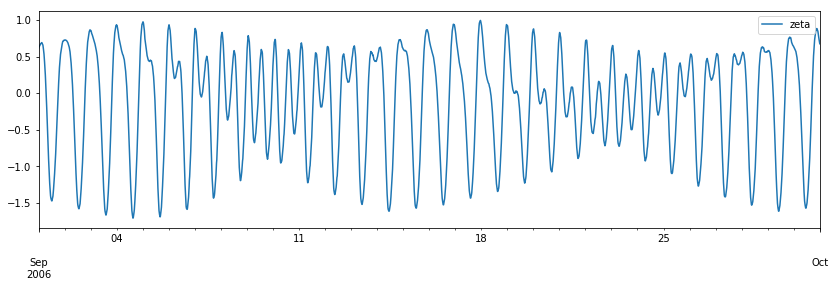

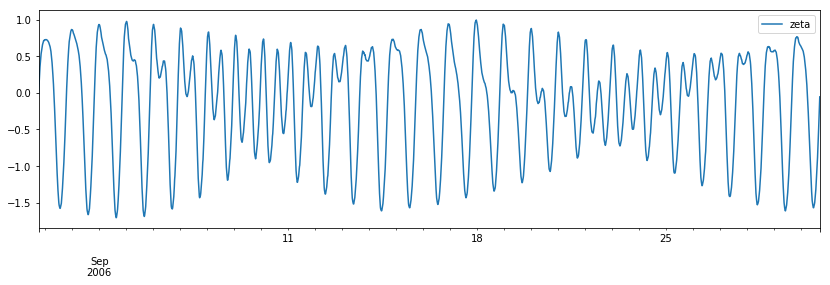

In [38]:
z.plot(figsize=(14,4))
z[72:-29].plot(figsize=(14,4))
istart = 72; iend = -29

In [50]:
Pbt = bt['P'][istart:iend].mean()/1e6
print()
print('Ratio of mixing to total dissipation: ', bt['Pmix'][istart:iend].mean()/Pbt*100)
print('Ratio of shear production to total dissipation: ', bt['Pmom'][istart:iend].mean()/Pbt*100)
print('Ratio of bottom friction to total dissipation: ', bt['Pfriction'][istart:iend].mean()/Pbt*100)
print('Ratio of diss terms to total: ', bt['terms'][istart:iend].mean()/Pbt*100)


Ratio of mixing to total dissipation:  8079177.78754476
Ratio of shear production to total dissipation:  28570662.108226966
Ratio of bottom friction to total dissipation:  52918899.951009825
Ratio of diss terms to total:  89568739.84678155


In [53]:
Pbc = bt['P'][istart:iend].mean()/1.e6
print('Difference between barotropic and baroclinic energy:', (Pbt-Pbc)/Pbc*100.)

Difference between barotropic and baroclinic energy: 0.0


### Baroclinic vs. barotropic (possibly connect with Arneborg)


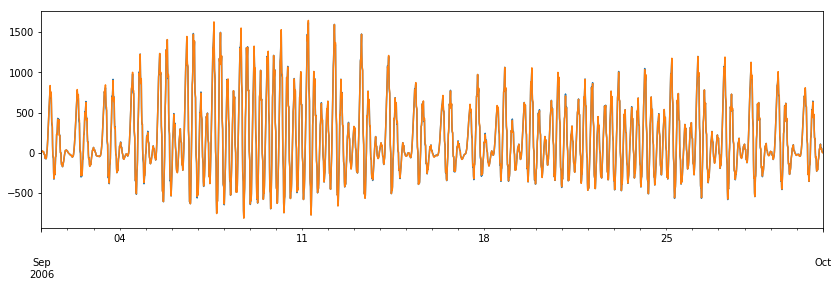

In [12]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
(bc['P']/1e6).plot(ax=ax)
(bt['P']/1e6).plot(ax=ax)

## Dissipation in time

### Lines



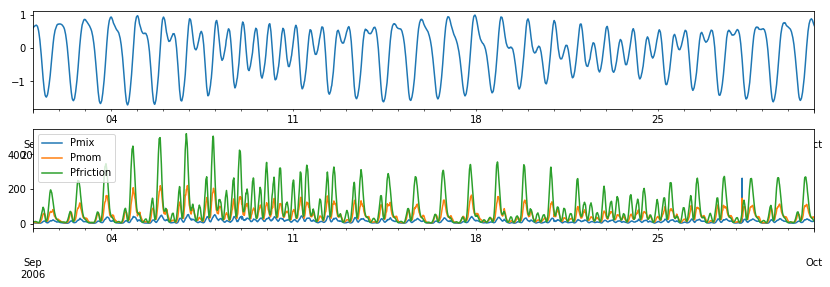

In [55]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(211)
bc['zeta'].plot(ax=ax)
ax = fig.add_subplot(212)
(bc[['Pmix','Pmom','Pfriction']]/1e6).plot(ax=ax)


### In space also

## Subdivide to calculate horizontal viscosity-based loss

In [3]:
df50s = []
for i in range(400)[::50]:
    df50s.append(pd.read_csv('savedoutput/power/stripsd50' + str(i) + '.csv', index_col=0, parse_dates=True))

In [4]:
len(df50s)

8

In [ ]:
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(top=0.96, bottom=0.02, left=0.06, right=0.99)
    ax = fig.add_subplot(111, projection=merc)#, facecolor='0.8')
    ax.set_extent(box, pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-122.8, -122.75, -122.7, -122.65, -122.6, -122.55, -122.5])
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    # plot coastline
    ax.contour(grid['lon_rho'][:], grid['lat_rho'][:], grid['mask_rho'][:], [0], colors='0.3', transform=pc, linewidths=1.5)
    # plot bathymetry
    if dobathy:
        ax.contour(grid['lon_rho'][:], grid['lat_rho'][:], h, np.arange(25,200,25), colors='0.3', transform=pc, linewidths=0.25)
